In [1]:
import desitarget 
from desitarget.targets import desi_mask, bgs_mask, mws_mask

from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
import astropy.units as U

import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [2]:
N = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_BRIGHT_N_clustering.dat.fits')
S = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_BRIGHT_S_clustering.dat.fits')
N['APPLIM'] = 19.539993
S['APPLIM'] = 19.5

In [30]:
data = Table(np.hstack((N,S))) #BGS ANY in N, S combined
data['ZLIM_UPPER'] = 0.6
data

RA,DEC,TARGETID,NTILE,TILES,Z,COMP_TILE,rosette_number,rosette_r,FRACZ_TILELOCID,BITWEIGHTS [2],PROB_OBS,WEIGHT_ZFAIL,WEIGHT,flux_g_dered,flux_r_dered,flux_z_dered,flux_w1_dered,flux_w2_dered,REST_GMR_0P1,KCORR_R0P1,KCORR_G0P1,KCORR_R0P0,KCORR_G0P0,REST_GMR_0P0,EQ_ALL_0P0,EQ_ALL_0P1,ABSMAG_R,NZ,WEIGHT_FKP,APPLIM,ZLIM_UPPER
float64,float64,int64,int64,bytes43,float64,float64,float64,float64,float64,int64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
191.20458196461243,60.31535787110577,39633390185481345,1,100,0.08969256109731599,0.64,3.0,1.613220114177946,1.0,-1 .. -1,1.0,1.0,1.0,11.618794,18.39226,20.892622,13.421043,9.27371,0.5107507237961553,-0.10918667636401896,-0.12125347071681446,0.09189331428141073,0.11205224487489494,0.47852499884987515,-0.08700178426439652,-0.08700178426439652,-17.752532357564764,0.04785387196770399,0.0030775738791196166,19.539993,0.6
187.04622815471808,60.82670180284912,39633396124617897,1,100,0.37400455377945924,0.64,3.0,1.6801915534232357,1.0,-1 .. -1,1.0,1.0,1.0,4.046807,16.82531,38.79777,85.02852,54.11833,0.8657535543881233,0.2757199965785285,0.9570932122099367,0.5034037640174682,1.319054690619937,0.7314758434170625,-0.36278441716607546,-0.36278441716607546,-21.20717884549835,0.0009571040215082368,0.13371119385114222,19.539993,0.6
187.83760708675698,60.38987543677365,39633393155049303,1,100,0.1731108191825362,0.64,3.0,1.7267282368438097,0.5,-6539912815536352385 .. 9025372152329235987,0.546875,1.0,1.8169014084507042,13.26433,27.728409,46.020153,37.03337,25.867756,0.6595463164766608,-0.04866411688213576,0.09238961852108621,0.17196093424278175,0.3785062363399163,0.5940547497827482,-0.16791749460706012,-0.16791749460706012,-19.719994580683654,0.012707690463455164,0.01149153305805754,19.539993,0.6
187.05117249536465,62.614542270156655,39633416324383107,1,100,0.2703579310142208,0.64,3.0,1.5579854421783794,1.0,-1 .. -1,1.0,1.0,1.0,4.4575434,17.798513,37.420948,46.075268,30.963612,0.9961770755006489,0.146409873660811,0.6534524026523496,0.3797334250181883,1.0502045184025013,0.8327485111078745,-0.2622471930837942,-0.2622471930837942,-20.42505494547267,0.004053776360776892,0.035160847734210195,19.539993,0.6
191.14757099005186,60.345815959235,39633390185480938,1,100,0.2819459922463374,0.64,3.0,1.5743490921284766,0.5,-8790991219464744880 .. -4387867067969646830,0.3203125,1.0,3.0714285714285716,6.782468,16.732075,29.996437,31.939342,25.343126,0.6031055527358372,-0.0007029256786438565,0.3765973290806362,0.21603985022885944,0.6418090846178732,0.5546365731061034,-0.27348761247894726,-0.27348761247894726,-20.30376568408361,0.004053776360776892,0.035160847734210195,19.539993,0.6
186.48359894373857,61.73967570511937,39633407801558322,1,100,0.08577825488213503,0.64,3.0,1.6169466967221486,1.0,-6189309032222493180 .. 7718245232114193986,0.421875,1.0,2.3454545454545452,15.079609,20.454126,26.065075,13.486019,10.797623,0.34480053237283675,-0.10549431291824019,-0.11931835908501928,0.06879194820524737,0.061135194940372256,0.3386332394709298,-0.08320490723567098,-0.08320490723567098,-17.77278795503906,0.04785387196770399,0.0030775738791196166,19.539993,0.6
189.28672536137475,60.18713259808659,39633390168704731,1,100,0.21452305283357412,0.64,3.0,1.6400346453345047,1.0,2333715480473687758 .. -1431821843982627288,0.4921875,1.0,2.015625,6.3314033,19.638945,38.222126,43.818123,28.204218,0.9059159293142172,0.04341174620827673,0.3665416848139814,0.27036648397159835,0.7431065827594778,0.7563057691320424,-0.2080873612485669,-0.2080873612485669,-19.915113465885533,0.009219810701767882,0.015770253951760238,19.539993,0.6
189.20703625254848,60.13450219401336,39633390168704208,1,100,0.1842724056985206,0.64,3.0,1.6990866107210438,0.5,-1 .. -1,1.0,1.0,1.0,20.873507,47.31153,86.10893,73.21894,58.1018,0.7111367437973818,-0.030741839754296674,0.1465510581719544,0.1934014143564434,0.4517835654815496,0.6300474905985266,-0.178

In [4]:
cosmo = FlatLambdaCDM(H0=100, Om0=0.3)
data['DL'] = cosmo.luminosity_distance(np.array(data['Z']))

In [5]:
data['ABSMAG_LIM'] = data['APPLIM'] - 5*np.log10(data['DL'])-25-data['KCORR_R0P1']-data['EQ_ALL_0P1']

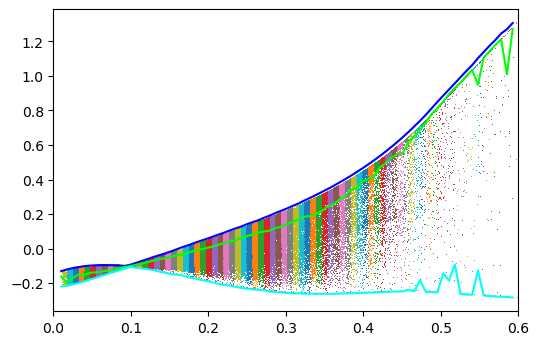

In [6]:
plt.figure(dpi=100)
def find_k(z_range, stat):
    if isinstance(z_range, np.ndarray):
        k = np.empty(len(z_range)-1)
        for i, z in enumerate(z_range):
            if i == len(z_range)-1:
                break
            z_close = np.where(np.logical_and(data['Z'] > (z), data['Z'] < (z_range[i+1])))[0]
            plt.plot(data['Z'][z_close], data['KCORR_R0P1'][z_close], lw=0, marker=',')
            if stat == 'med':
                k[i] = np.median(data['KCORR_R0P1'][z_close])
            elif stat == 'max':
                k[i] = np.amax(data['KCORR_R0P1'][z_close])
            elif stat == 'min':
                k[i] = np.amin(data['KCORR_R0P1'][z_close])
        return k


z_range = np.linspace(0.01,0.6,80)  
M_range = np.arange(-23,-16,0.01)
k_med = find_k(z_range, 'med') 
k_max = find_k(z_range, 'max')
k_min = find_k(z_range, 'min')
plt.plot(z_range[0:-1], k_max, color='blue')
plt.plot(z_range[0:-1], k_med, color='lime')
plt.plot(z_range[0:-1], k_min, color='aqua')

plt.xlim(0,0.6)
plt.show()

In [7]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

Finding linear evolution E(z) from data

In [9]:
z1 = find_nearest(data['Z'], 0.1)
z2 = find_nearest(data['Z'], 0.5)
e_slope = (data['EQ_ALL_0P1'][z2] - data['EQ_ALL_0P1'][z1])/(data['Z'][z2] - data['Z'][z1])
print(data['Z'][z2], data['EQ_ALL_0P1'][z2])
print(data['Z'][z1], data['EQ_ALL_0P1'][z1])
print(e_slope)

e_intercept = data['EQ_ALL_0P1'][z2] - e_slope*data['Z'][z2]
print(e_intercept)
#y = mx+c

0.5000411802639463 -0.48503994485602786
0.10000013207827435 -0.09700012811592612
-0.9699999999999999
-5.551115123125783e-17


Using evolution equation to find limits as function of z

In [10]:
dl_range = cosmo.luminosity_distance(z_range[0:-1]).to_value()
e_z = e_slope*z_range[0:-1] + e_intercept
faintlim_range_N_max = 19.539993 - 5*np.log10(dl_range) - 25 - k_max - e_z
faintlim_range_S_max = 19.5  - 5*np.log10(dl_range) - 25 - k_max - e_z

faintlim_range_N_min = 19.539993 - 5*np.log10(dl_range) - 25 - k_min - e_z
faintlim_range_S_min = 19.5  - 5*np.log10(dl_range) - 25 - k_min - e_z

faintlim_range_N_med = 19.539993 - 5*np.log10(dl_range) - 25 - k_med - e_z
faintlim_range_S_med = 19.5  - 5*np.log10(dl_range) - 25 - k_med - e_z

brightlim_range_max = 15 - 5*np.log10(dl_range) - 25 - k_max - e_z
brightlim_range_min = 15 - 5*np.log10(dl_range) - 25 - k_min - e_z
brightlim_range_med = 15 - 5*np.log10(dl_range) - 25 - k_med - e_z

In [53]:
def absmag_lim(lim0, lim1, cat):
    return np.where(np.logical_and(cat['ABSMAG_R'] < lim0, cat['ABSMAG_R'] > lim1))

def find_zmax(M):
    z_array = []
    for m in M:
        i = find_nearest(faintlim_range_S_min, m) #ignore faintlim differences between S and N (use 19.5)
        z_array.append(z_range[i])
    return z_array

def redshift_lim_from_k(lim0, lim1, cat):
    N_i = np.where(cat['APPLIM'] == 19.539993)
    S_i = np.where(cat['APPLIM'] == 19.5)
    zlim_upper_S = z_range[find_nearest(faintlim_range_S_max,lim0)]
    zlim_upper_N =  z_range[find_nearest(faintlim_range_N_max,lim0)]
    cat['ZLIM_UPPER'][S_i] = zlim_upper_S
    cat['ZLIM_UPPER'][N_i] = zlim_upper_N

    upper_limed = np.where(cat['Z'] < np.minimum(cat['ZLIM_UPPER'],0.6))
    z_lim_lower = z_range[find_nearest(brightlim_range_min,lim1)]
    return [[zlim_upper_N, zlim_upper_S], z_lim_lower], np.intersect1d(upper_limed, np.where(cat['Z'] > z_lim_lower))

      

print(redshift_lim_from_k(-22,-23, data)[0])

data['ZMAX'] = find_zmax(data['ABSMAG_R'])

[[0.46556962025316456, 0.4581012658227848], 0.1369620253164557]


plot of corrections and resulting absmag limits, for different k

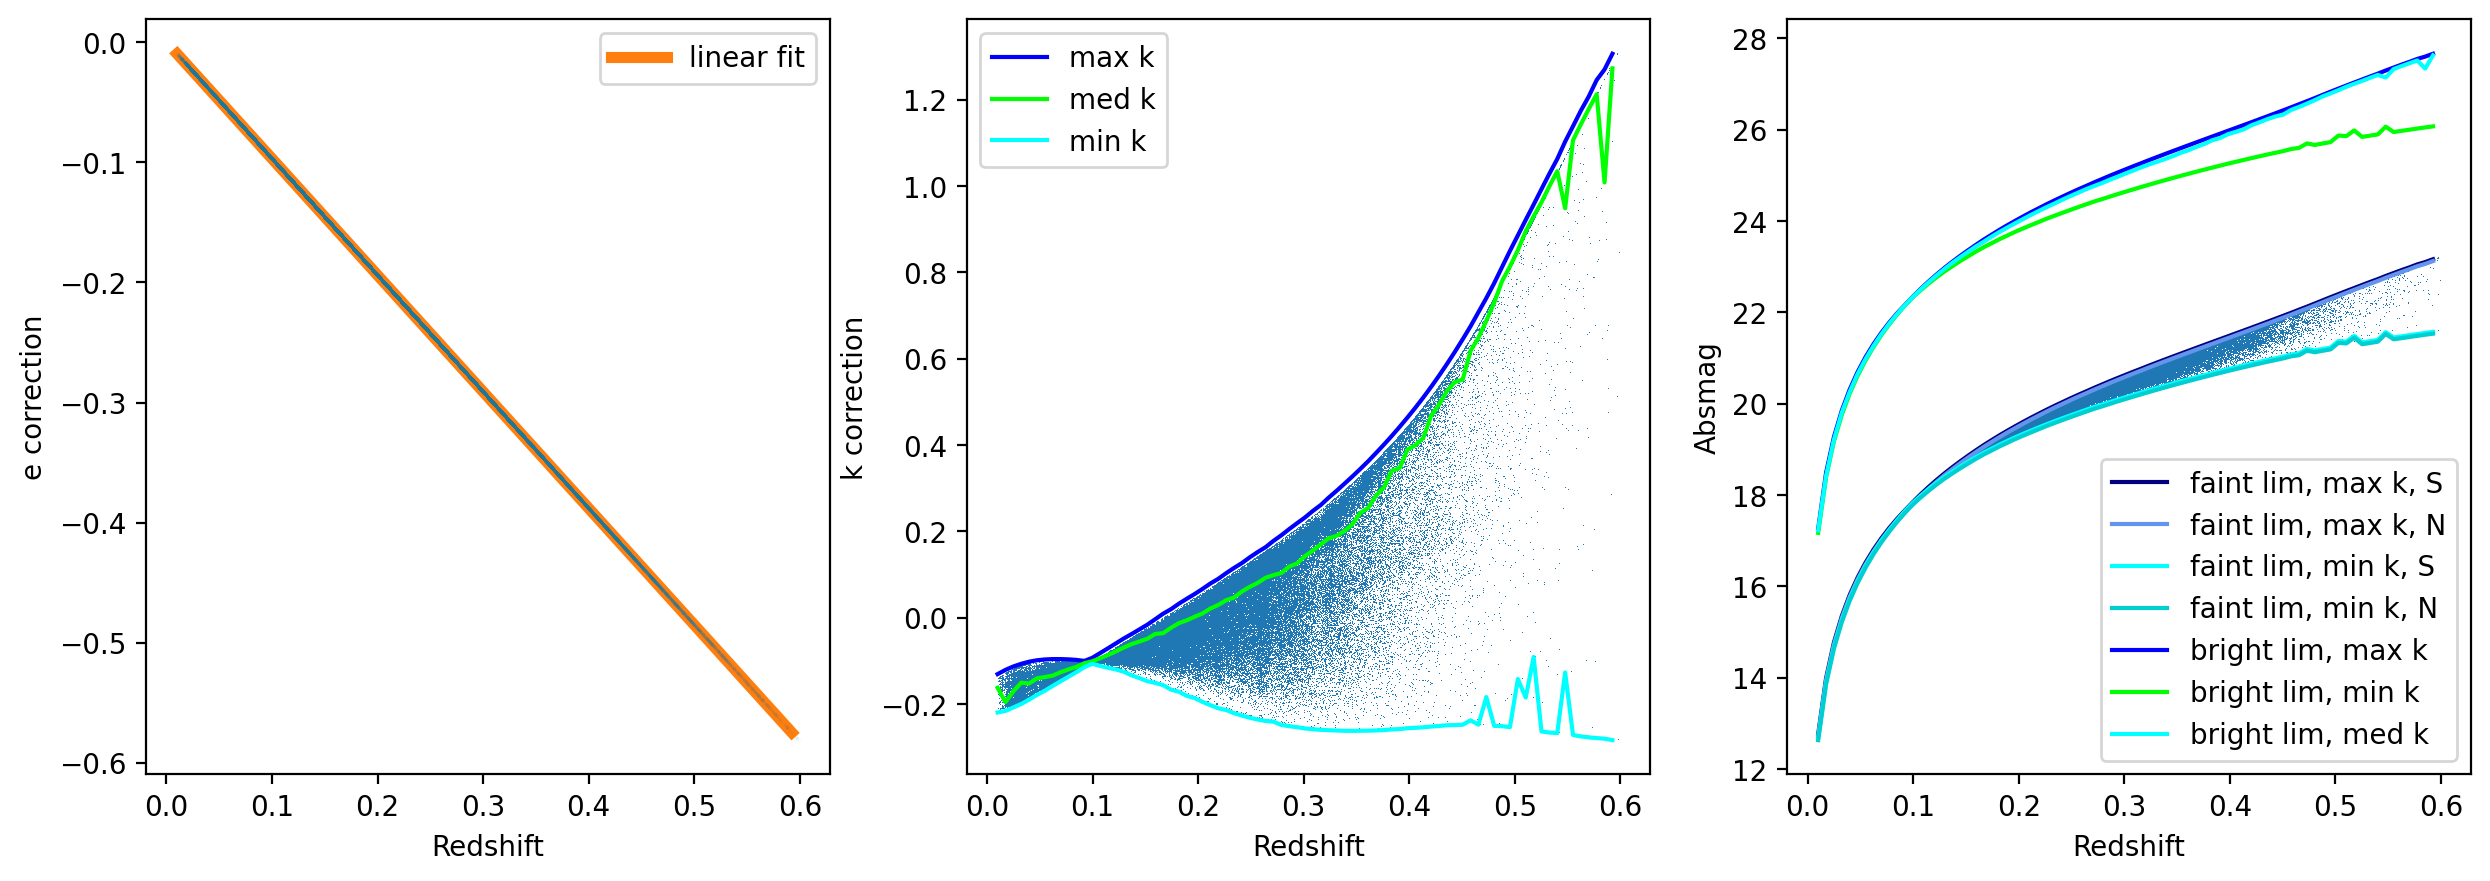

In [14]:
plt.figure(figsize=(15,5), dpi=200)

plt.subplot(131)
plt.plot(z_range[0:-1], e_z, label='linear fit', color='tab:orange', lw=4)
plt.plot(data['Z'], data['EQ_ALL_0P1'], lw=0, marker='o', color='tab:blue', markersize=0.01)
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('e correction')

plt.subplot(132)
plt.plot(data['Z'], data['KCORR_R0P1'], lw=0, marker=',')
plt.plot(z_range[0:-1], k_max, color='blue', label='max k')
plt.plot(z_range[0:-1], k_med, color='lime', label='med k')
plt.plot(z_range[0:-1], k_min, color='aqua', label='min k')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('k correction')

plt.subplot(133)
plt.plot(data['Z'], -data['ABSMAG_LIM'], lw=0, marker=',')
plt.plot(z_range[0:-1], -faintlim_range_S_max, color='navy', label='faint lim, max k, S')
plt.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
#plt.plot(z_range[0:-1], -faintlim_range_S_med, color='lime', label='med k, S')
#plt.plot(z_range[0:-1], -faintlim_range_N_med, color='palegreen', label='med k, N')
plt.plot(z_range[0:-1], -faintlim_range_S_min, color='aqua', label='faint lim, min k, S')
plt.plot(z_range[0:-1], -faintlim_range_N_min, color='darkturquoise', label='faint lim, min k, N')
plt.plot(z_range[0:-1], -brightlim_range_max, color='blue', label='bright lim, max k')
plt.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
plt.plot(z_range[0:-1], -brightlim_range_med, color='aqua', label='bright lim, med k')

plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Absmag')
plt.savefig('../figures/week8-9/sv3_bright_corrections_and_absmag.png')


Plot of all data, the lims, and resulting volume-limited bins

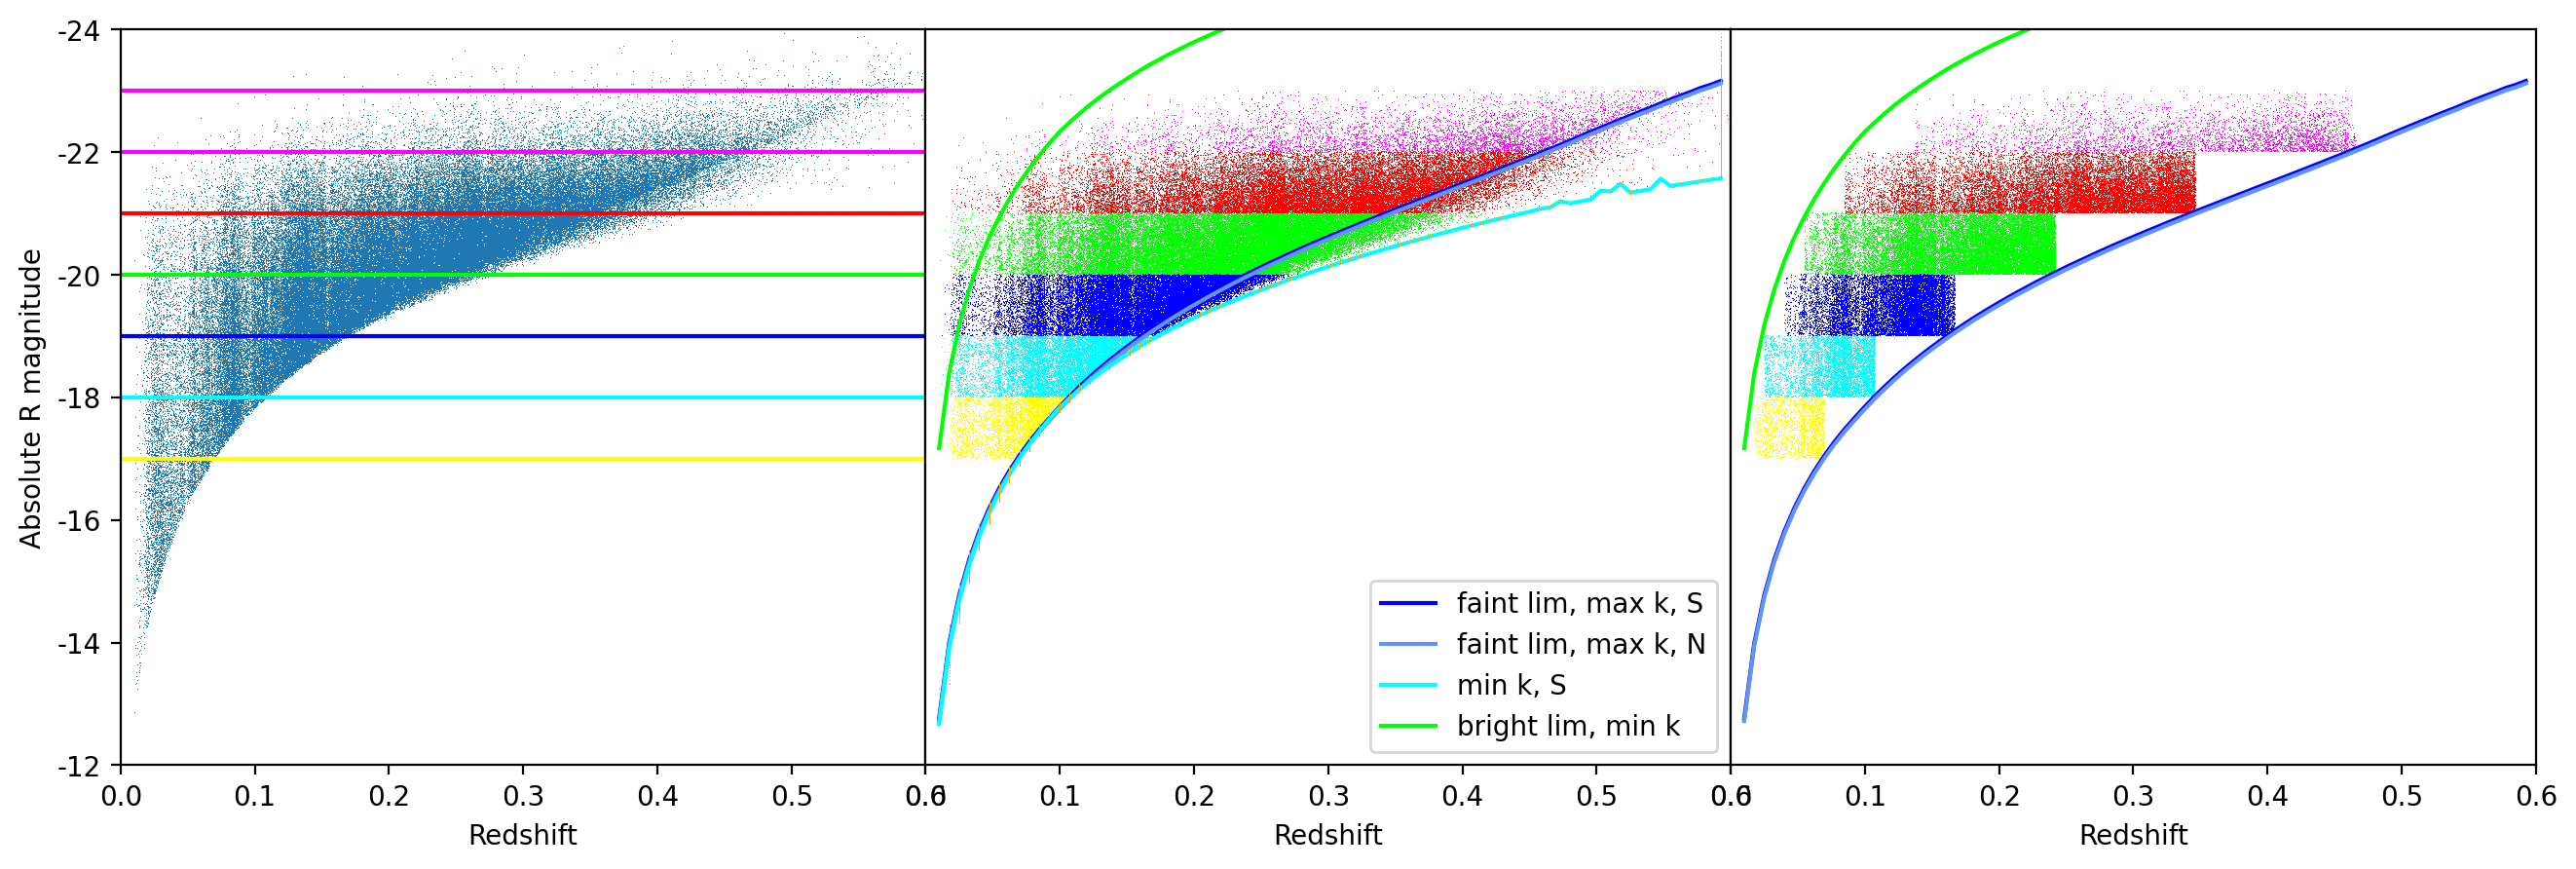

In [55]:
plt.figure(figsize=(16,5), dpi=200)
ax1 = plt.subplot(131)
ax1.plot(data['Z'], -data['ABSMAG_R'], lw=0, marker=',')
ax1.plot([0,0.6],[17,17], color='yellow')
ax1.plot([0,0.6],[18,18], color='cyan')
ax1.plot([0,0.6],[19,19], color='blue')
ax1.plot([0,0.6],[20,20], color='lime')
ax1.plot([0,0.6],[21,21], color='red')
ax1.plot([0,0.6],[22,22], color='magenta')
ax1.plot([0,0.6],[23,23], color='magenta')
plt.ylim(12,24)
plt.xlim(0,0.6)
plt.yticks([12,14,16,18,20,22,24],['-12','-14','-16','-18','-20','-22','-24'])
plt.xlabel('Redshift')
plt.ylabel('Absolute R magnitude')

ax2 = plt.subplot(132)
ax2.plot(data['Z'][absmag_lim(-17,-18, data)], -data['ABSMAG_R'][absmag_lim(-17,-18, data)], lw=0, marker=',', color='yellow')
ax2.plot(data['Z'][absmag_lim(-18,-19, data)], -data['ABSMAG_R'][absmag_lim(-18,-19, data)], lw=0, marker=',', color='cyan')
ax2.plot(data['Z'][absmag_lim(-19,-20, data)], -data['ABSMAG_R'][absmag_lim(-19,-20, data)], lw=0, marker=',', color='blue')
ax2.plot(data['Z'][absmag_lim(-20,-21, data)], -data['ABSMAG_R'][absmag_lim(-20,-21, data)], lw=0, marker=',', color='lime')
ax2.plot(data['Z'][absmag_lim(-21,-22, data)], -data['ABSMAG_R'][absmag_lim(-21,-22, data)], lw=0, marker=',', color='red')
ax2.plot(data['Z'][absmag_lim(-22,-23, data)], -data['ABSMAG_R'][absmag_lim(-22,-23, data)], lw=0, marker=',', color='magenta')
#ax2.plot(zmax_range, -M_range, color='tab:blue', lw=1, label='my estimate')
ax2.plot(z_range[0:-1], -faintlim_range_S_max, color='blue', label='faint lim, max k, S')
ax2.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
#plt.plot(z_range[0:-1], -faintlim_range_S_med, color='lime', label='med k, S')

plt.plot(z_range[0:-1], -faintlim_range_S_min, color='aqua', label='min k, S')
#plt.plot(z_range[0:-1], -brightlim_range_max, color='blue', label='bright lim, max k')
ax2.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
#plt.plot(z_range[0:-1], -brightlim_range_med, color='aqua', label='bright lim, med k')

ax2.plot(data['ZMAX'], -data['ABSMAG_R'], lw=0, marker=',', color='orange')


plt.legend()
plt.yticks([])
plt.ylim(12,24)
plt.xlim(0,0.6)
plt.xlabel('Redshift')

ax3 = plt.subplot(133)
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-17,-18, data), redshift_lim_from_k(-17,-18, data)[1])], -data['ABSMAG_R'][np.intersect1d(absmag_lim(-17,-18, data), redshift_lim_from_k(-17,-18, data)[1])], lw=0, marker=',', color='yellow')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-18,-19, data), redshift_lim_from_k(-18,-19, data)[1])], -data['ABSMAG_R'][np.intersect1d(absmag_lim(-18,-19, data), redshift_lim_from_k(-18,-19, data)[1])], lw=0, marker=',', color='cyan')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-19,-20, data), redshift_lim_from_k(-19,-20, data)[1])], -data['ABSMAG_R'][np.intersect1d(absmag_lim(-19,-20, data), redshift_lim_from_k(-19,-20, data)[1])], lw=0, marker=',', color='blue')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-20,-21, data), redshift_lim_from_k(-20,-21, data)[1])], -data['ABSMAG_R'][np.intersect1d(absmag_lim(-20,-21, data), redshift_lim_from_k(-20,-21, data)[1])], lw=0, marker=',', color='lime')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-21,-22, data), redshift_lim_from_k(-21,-22, data)[1])], -data['ABSMAG_R'][np.intersect1d(absmag_lim(-21,-22, data), redshift_lim_from_k(-21,-22, data)[1])], lw=0, marker=',', color='red')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-22,-23, data), redshift_lim_from_k(-22,-23, data)[1])], -data['ABSMAG_R'][np.intersect1d(absmag_lim(-22,-23, data), redshift_lim_from_k(-22,-23, data)[1])], lw=0, marker=',', color='magenta')
ax3.plot(z_range[0:-1], -faintlim_range_S_max, color='blue', label='faint lim, max k, S')
ax3.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
ax3.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
plt.yticks([])
plt.ylim(12,24)
plt.xlim(0,0.6)

plt.xlabel('Redshift')
plt.subplots_adjust(wspace=0)
plt.savefig('../figures/week8-9/sv3_bright_mag_v_redshift.png')


Luminosity function

In [16]:
def phi(M, phi_star=8.32*10**(-3), M_star=-20.3, alpha=-0.23): #luminosity function
    return np.log(10)*phi_star*10**(0.4*(alpha+1)*(-M+M_star))*np.exp(-10**(0.4*(-M+M_star)))/2.5

with open('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/BGS_BRIGHT_N_nz.txt') as file:
    print('N')
    print(file.read())

with open('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/BGS_BRIGHT_S_nz.txt') as file:
    print('S')
    print(file.read())

In [17]:
A = 86.2884+87.204
sky_area = 4*np.pi*np.rad2deg(1)**2
fsky_hdr = A/sky_area
print(fsky_hdr)

0.004205574454426402


In [34]:
zmax_clipped = np.clip(data['ZMAX'], a_min=None, a_max=0.3)
data['VMAX'] = fsky_hdr*cosmo.comoving_volume(zmax_clipped)
print(data['ZMAX'])

        ZMAX       
-------------------
0.09962025316455696
 0.4730379746835443
 0.2489873417721519
0.34607594936708863
0.32367088607594935
0.09962025316455696
0.27139240506329115
0.34607594936708863
0.38341772151898734
 0.5925316455696202
                ...
 0.3983544303797468
0.09962025316455696
 0.5925316455696202
 0.3535443037974684
 0.4879746835443038
 0.3012658227848101
0.34607594936708863
0.18924050632911393
 0.5178481012658228
 0.5925316455696202
0.34607594936708863
Length = 143853 rows


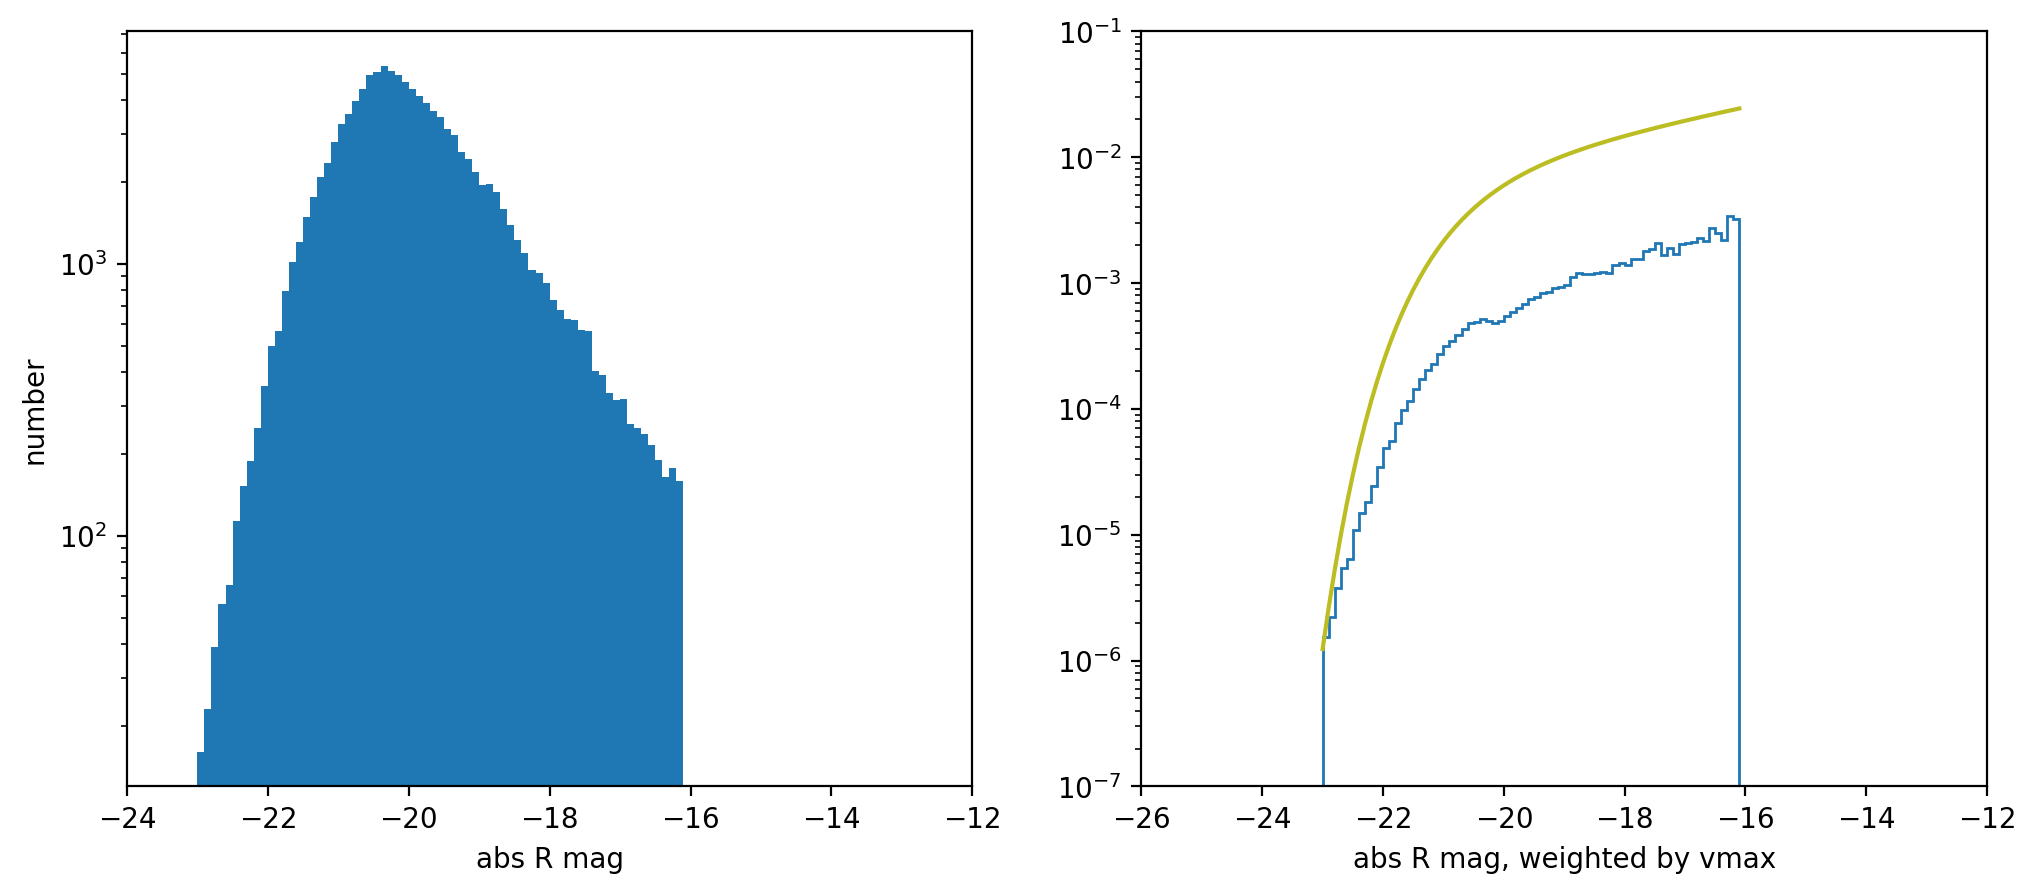

In [35]:
phi_star_est = 0.00000000003
M_star_est = -22 #-21.5#-19.7+5*np.log10(5) for b-band
alpha_est = -1.25 #-1.07
M_range = np.arange(-23,-16,0.1)
redshift_cut = np.where(data['Z'] <= 0.3)[0]

plt.figure(figsize=(12,5),dpi=200)
ax1 = plt.subplot(121)
ax1.hist(data['ABSMAG_R'][redshift_cut], bins=M_range)
ax1.set_yscale('log')
plt.xlabel('abs R mag')
plt.ylabel('number')
plt.xlim(-24,-12)
ax2 = plt.subplot(122)
ax2.set_yscale('log')
ax2.hist(data['ABSMAG_R'][redshift_cut], bins=M_range, weights=1/data['VMAX'][redshift_cut], histtype='step')
#ax2.plot(M_range, phi(M_range, phi_star=0.000000000015, M_star=-20, alpha=-1.02))
ax2.plot(M_range, phi(M_range, phi_star=10**(-2.03), M_star=-20.7, alpha=-1.25), color='tab:olive')
plt.xlabel('abs R mag, weighted by vmax')
plt.ylim(10**-7,10**-1)
plt.xlim(-26,-12)
plt.savefig('../figures/week8-9/sv3_LF.png')

v/vmax plot?

In [117]:
def vmax(lim0, lim1):
    r1 = cosmo.comoving_distance(redshift_lim_from_k(lim0,lim1,data)[0][1])
    z2_N = redshift_lim_from_k(lim0,lim1,data)[0][0][0]
    z2_S = redshift_lim_from_k(lim0,lim1,data)[0][0][1]
    r2_N = cosmo.comoving_distance(z2_N)
    r2_S = cosmo.comoving_distance(z2_S)
    plt.scatter([z2_N,z2_S], [1,1])
    print(z2_N, z2_S)
    v_N = (4/3)*np.pi*fsky_hdr*(r2_N**3-r1**3).to_value()
    v_S = (4/3)*np.pi*fsky_hdr*(r2_S**3-r1**3).to_value()
    return [v_N,v_S] #Mpc**3/h

def v(lim0,lim1,z2):
    r1 = cosmo.comoving_distance(redshift_lim_from_k(lim0,lim1,data)[0][1])
    r2 = cosmo.comoving_distance(z2)
    return (4/3)*np.pi*fsky_hdr*(r2**3-r1**3).to_value()


print(redshift_lim_from_k(-22,-23,data)[0]) #[[N,S upper], lower]
print(redshift_lim_from_k(-20,-21,data)[0][0][1])

[[0.46556962025316456, 0.4581012658227848], 0.1369620253164557]
0.24151898734177216


0.06974683544303797 0.06974683544303797
0.1070886075949367 0.1070886075949367
0.16683544303797468 0.15936708860759494
0.24151898734177216 0.24151898734177216
0.34607594936708863 0.34607594936708863
0.46556962025316456 0.4581012658227848

0.06974683544303797 0.06974683544303797
0.1070886075949367 0.1070886075949367
0.16683544303797468 0.15936708860759494
0.24151898734177216 0.24151898734177216
0.34607594936708863 0.34607594936708863
0.46556962025316456 0.4581012658227848


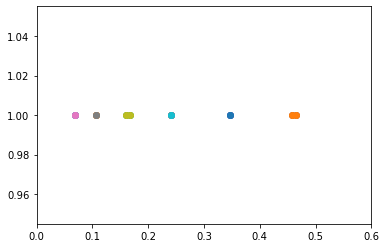

In [136]:
plt.figure()
data_magbins_N = Table()
data_magbins_N['TARGETID'] = N['TARGETID']
data_magbins_N['Z'] = N['Z']
data_magbins_N['WEIGHT'] = N['WEIGHT']
data_magbins_N['Vmax1718'] = vmax(-17,-18)[0]
data_magbins_N['Vmax1819'] = vmax(-18,-19)[0]
data_magbins_N['Vmax1920'] = vmax(-19,-20)[0]
data_magbins_N['Vmax2021'] = vmax(-20,-21)[0]
data_magbins_N['Vmax2122'] = vmax(-21,-22)[0]
data_magbins_N['Vmax2223'] = vmax(-22,-23)[0]
print('')
data_magbins_S = Table()
data_magbins_S['TARGETID'] = S['TARGETID']
data_magbins_S['Z'] = S['Z']
data_magbins_S['WEIGHT'] = S['WEIGHT']
data_magbins_S['Vmax1718'] = vmax(-17,-18)[1]
data_magbins_S['Vmax1819'] = vmax(-18,-19)[1]
data_magbins_S['Vmax1920'] = vmax(-19,-20)[1]
data_magbins_S['Vmax2021'] = vmax(-20,-21)[1]
data_magbins_S['Vmax2122'] = vmax(-21,-22)[1]
data_magbins_S['Vmax2223'] = vmax(-22,-23)[1]
plt.xlim(0,0.6)
plt.show()

In [137]:
data_magbins = Table(np.hstack((data_magbins_N, data_magbins_S)))
data_magbins['V1718'] = v(-17,-18,data_magbins['Z']) 
data_magbins['V1819'] = v(-18,-19,data_magbins['Z']) 
data_magbins['V1920'] = v(-19,-20,data_magbins['Z']) 
data_magbins['V2021'] = v(-20,-21,data_magbins['Z']) 
data_magbins['V2122'] = v(-21,-22,data_magbins['Z']) 
data_magbins['V2223'] = v(-22,-23,data_magbins['Z']) 

In [138]:
data_magbins

TARGETID,Z,WEIGHT,Vmax1718,Vmax1819,Vmax1920,Vmax2021,Vmax2122,Vmax2223,V1718,V1819,V1920,V2021,V2122,V2223
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633390185481345,0.08969256109731599,1.0,150980.20457945947,533736.8929965965,1929165.9847492354,5543034.585160442,14977420.635704989,32671749.145471014,319322.3355410017,314586.15126641176,292541.4550143496,246554.59097374228,49996.880766910144,-785724.0903678577
39633396124617897,0.37400455377945924,1.0,150980.20457945947,533736.8929965965,1929165.9847492354,5543034.585160442,14977420.635704989,32671749.145471014,18827655.317537714,18822919.133263122,18800874.43701106,18754887.572970454,18558329.86276362,17722608.891628854
39633393155049303,0.1731108191825362,1.8169014084507042,150980.20457945947,533736.8929965965,1929165.9847492354,5543034.585160442,14977420.635704989,32671749.145471014,2175235.371078539,2170499.1868039495,2148454.490551887,2102467.62651128,1905909.9163044477,1070188.9451696798
39633416324383107,0.2703579310142208,1.0,150980.20457945947,533736.8929965965,1929165.9847492354,5543034.585160442,14977420.635704989,32671749.145471014,7706796.794686723,7702060.610412133,7680015.914160071,7634029.050119464,7437471.3399126325,6601750.368777864
39633390185480938,0.2819459922463374,3.0714285714285716,150980.20457945947,533736.8929965965,1929165.9847492354,5543034.585160442,14977420.635704989,32671749.145471014,8663770.431826545,8659034.247551955,8636989.551299894,8591002.687259287,8394444.977052454,7558724.005917686
39633407801558322,0.08577825488213503,2.3454545454545452,150980.20457945947,533736.8929965965,1929165.9847492354,5543034.585160442,14977420.635704989,32671749.145471014,279784.5501757784,275048.36590118846,253003.66964912633,207016.80560851897,10459.095401686842,-825261.8757330811
39633390168704731,0.21452305283357412,2.015625,150980.20457945947,533736.8929965965,1929165.9847492354,5543034.585160442,14977420.635704989,32671749.145471014,4015718.6244047536,4010982.4401301634,3988937.7438781015,3942950.8798374934,3746393.1696306616,2910672.1984958937
39633390168704208,0.1842724056985206,1.0,150980.20457945947,533736.8929965965,1929165.9847492354,5543034.585160442,14977420.635704989,32671749.145471014,2602559.527737283,2597823.343462693,2575778.647210631,2529791.7831700235,2333234.072963191,1497513.1018284233
39633390164510257,0.2854181586411897,3.6857142857142855,150980.20457945947,533736.8929965965,1929165.9847492354,5543034.585160442,14977420.635704989,32671749.145471014,8963923.126160033,8959186.941885442,8937142.24563338,8891155.381592773,8694597.671385942,7858876.700251172


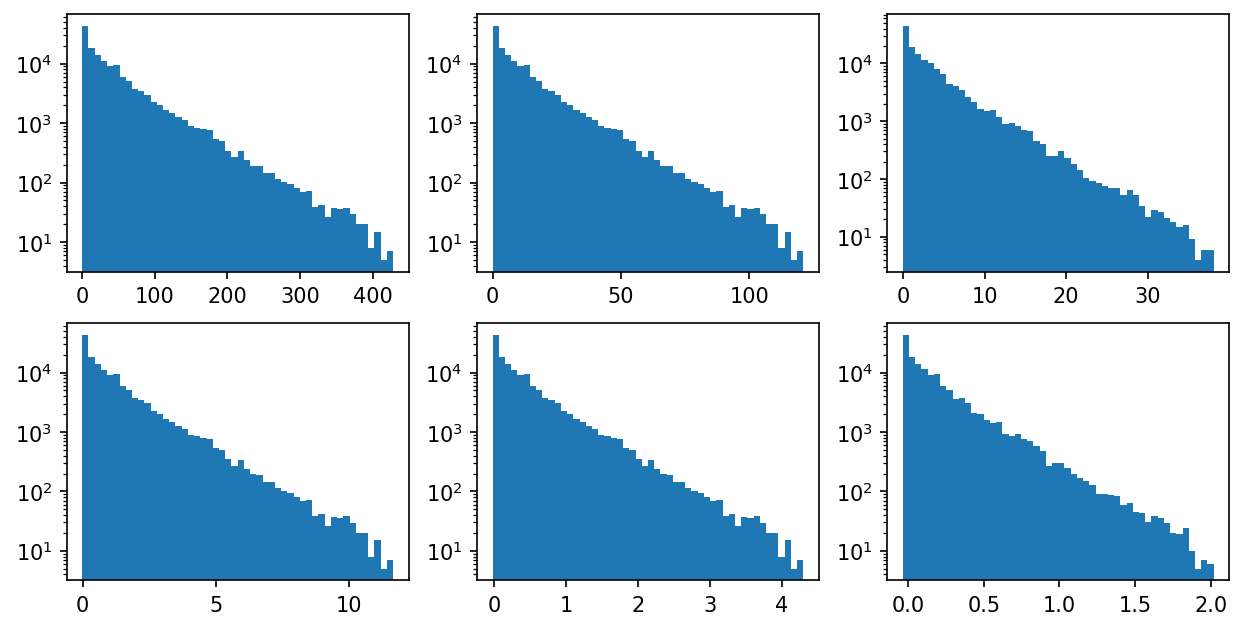

In [158]:
plt.figure(figsize=(10,5),dpi=150)
ax1 = plt.subplot(231)
ax1.hist(data_magbins['V1718']/data_magbins['Vmax1718'], bins=50)
ax1.set_yscale('log')


ax2 = plt.subplot(232)
ax2.hist(data_magbins['V1819']/data_magbins['Vmax1819'], bins=50)
ax2.set_yscale('log')


ax3 = plt.subplot(233)
ax3.hist(data_magbins['V1920']/data_magbins['Vmax1920'], bins=50)
ax3.set_yscale('log')


ax4 = plt.subplot(234)
ax4.hist(data_magbins['V2021']/data_magbins['Vmax2021'], bins=50)
ax4.set_yscale('log')


ax5 = plt.subplot(235)
ax5.hist(data_magbins['V2122']/data_magbins['Vmax2122'], bins=50)
ax5.set_yscale('log')


ax6 = plt.subplot(236)
ax6.hist(data_magbins['V2223']/data_magbins['Vmax2223'], bins=50)
ax6.set_yscale('log')


plt.savefig('../figures/week9/sv3_v_vmax_raw.png')

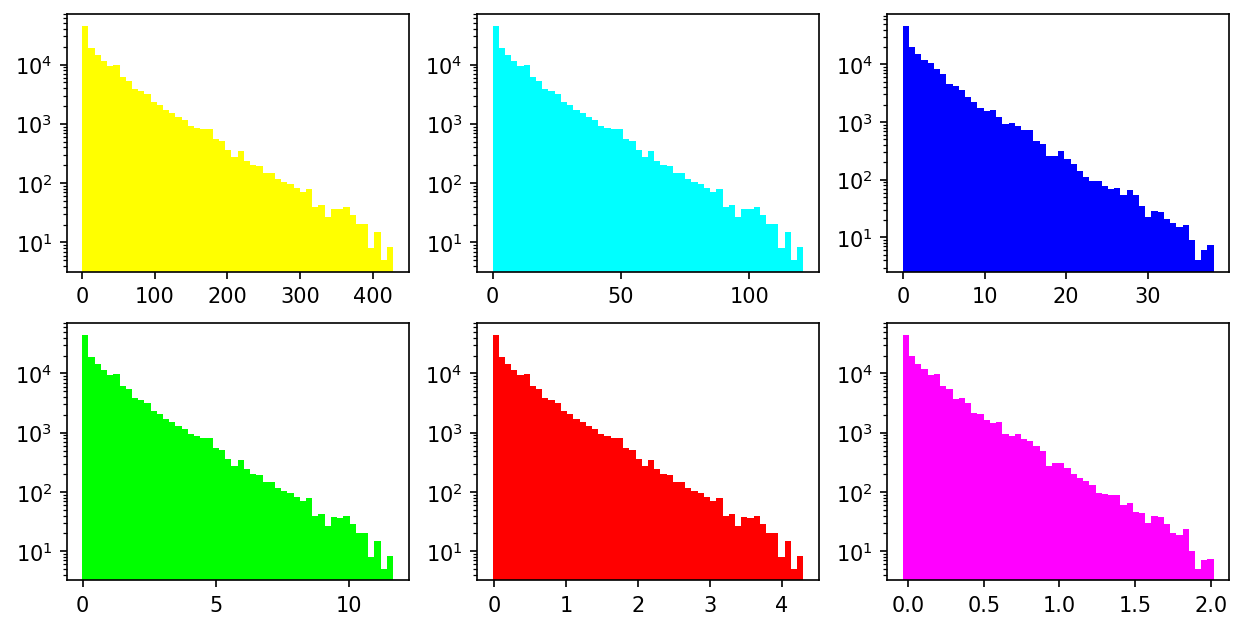

In [155]:
plt.figure(figsize=(10,5),dpi=150)
ax1 = plt.subplot(231)
ax1.hist(data_magbins['V1718']/data_magbins['Vmax1718'], bins=50, weights=data_magbins['WEIGHT'], color='yellow')
ax1.set_yscale('log')


ax2 = plt.subplot(232)
ax2.hist(data_magbins['V1819']/data_magbins['Vmax1819'], bins=50, weights=data_magbins['WEIGHT'], color='aqua')
ax2.set_yscale('log')


ax3 = plt.subplot(233)
ax3.hist(data_magbins['V1920']/data_magbins['Vmax1920'], bins=50, weights=data_magbins['WEIGHT'], color='blue')
ax3.set_yscale('log')


ax4 = plt.subplot(234)
ax4.hist(data_magbins['V2021']/data_magbins['Vmax2021'], bins=50, weights=data_magbins['WEIGHT'], color='lime')
ax4.set_yscale('log')


ax5 = plt.subplot(235)
ax5.hist(data_magbins['V2122']/data_magbins['Vmax2122'], bins=50, weights=data_magbins['WEIGHT'], color='red')
ax5.set_yscale('log')


ax6 = plt.subplot(236)
ax6.hist(data_magbins['V2223']/data_magbins['Vmax2223'], bins=50, weights=data_magbins['WEIGHT'], color='magenta')
ax6.set_yscale('log')


plt.savefig('../figures/week9/sv3_v_vmax_weighted.png')

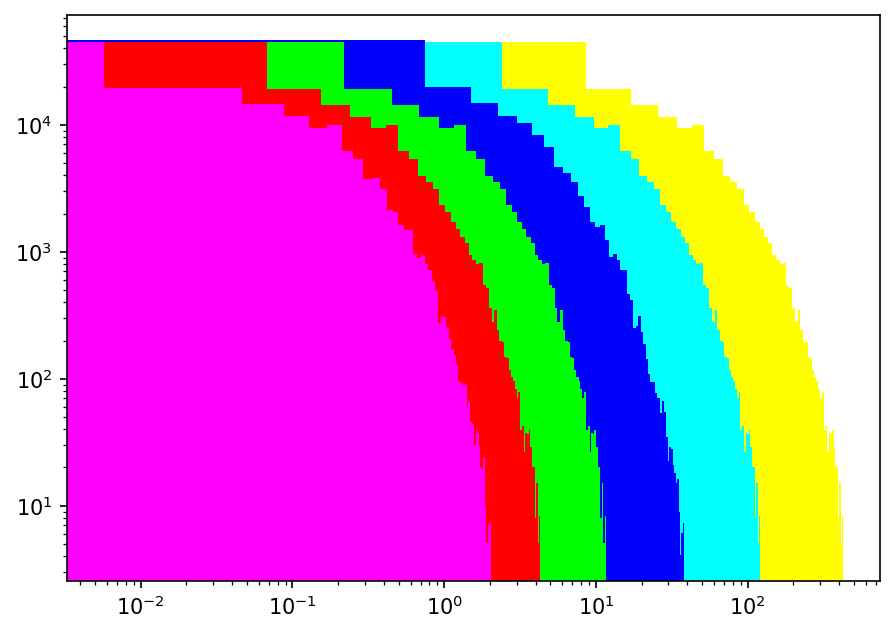

In [156]:
fig, ax = plt.subplots(figsize=(7,5),dpi=150)
ax.set_yscale('log')
ax.set_xscale('log')
ax.hist(data_magbins['V1718']/data_magbins['Vmax1718'], bins=50, weights=data_magbins['WEIGHT'], color='yellow')
ax.hist(data_magbins['V1819']/data_magbins['Vmax1819'], bins=50, weights=data_magbins['WEIGHT'], color='aqua')
ax.hist(data_magbins['V1920']/data_magbins['Vmax1920'], bins=50, weights=data_magbins['WEIGHT'], color='blue')
ax.hist(data_magbins['V2021']/data_magbins['Vmax2021'], bins=50, weights=data_magbins['WEIGHT'], color='lime')
ax.hist(data_magbins['V2122']/data_magbins['Vmax2122'], bins=50, weights=data_magbins['WEIGHT'], color='red')
ax.hist(data_magbins['V2223']/data_magbins['Vmax2223'], bins=50, weights=data_magbins['WEIGHT'], color='magenta')

plt.savefig('../figures/week9/sv3_v_vmax_weighted_ontop.png')